# ROPE should be in float32 instead of bfloat16

### Purpose
There were several issues reported on X regarding discrepancies in ROPE when using bfloat16.
https://x.com/danielhanchen/status/1862979480274555297


### Problem
Track if it makes sense to use bfloat32 for ROPE.
### Process
* Track if it makes sense to use bfloat32 for ROPE.
* Do some kind of benchmark to see if perf downgrade is significant.

In [1]:
import torch
import pytest
import matplotlib.pyplot as plt
from models.gpt_2_baseline_liger import Attention, GPT2Configuration
from liger_kernel.transformers.rope import LigerRopeFunction
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb


/home/tsikora/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Analysis of freqs_cis_matrix

In [2]:
def precompute_freqs_cis(dim: int, end: int, device=None, theta=10000.0, dtype_r=torch.float32):
 # Make sure we're using half dimension since we'll duplicate later

    # This is the key change - use torch.arange(0, dim, 2) instead of just torch.arange
    freqs = 1.0 / (theta ** (torch.arange(0, dim , 2, dtype=dtype_r) / (dim)))

    t = torch.arange(end, device=freqs.device, dtype=dtype_r)
    freqs = torch.outer(t, freqs)  # [end, dim/2]

    return torch.cos(freqs), torch.sin(freqs)


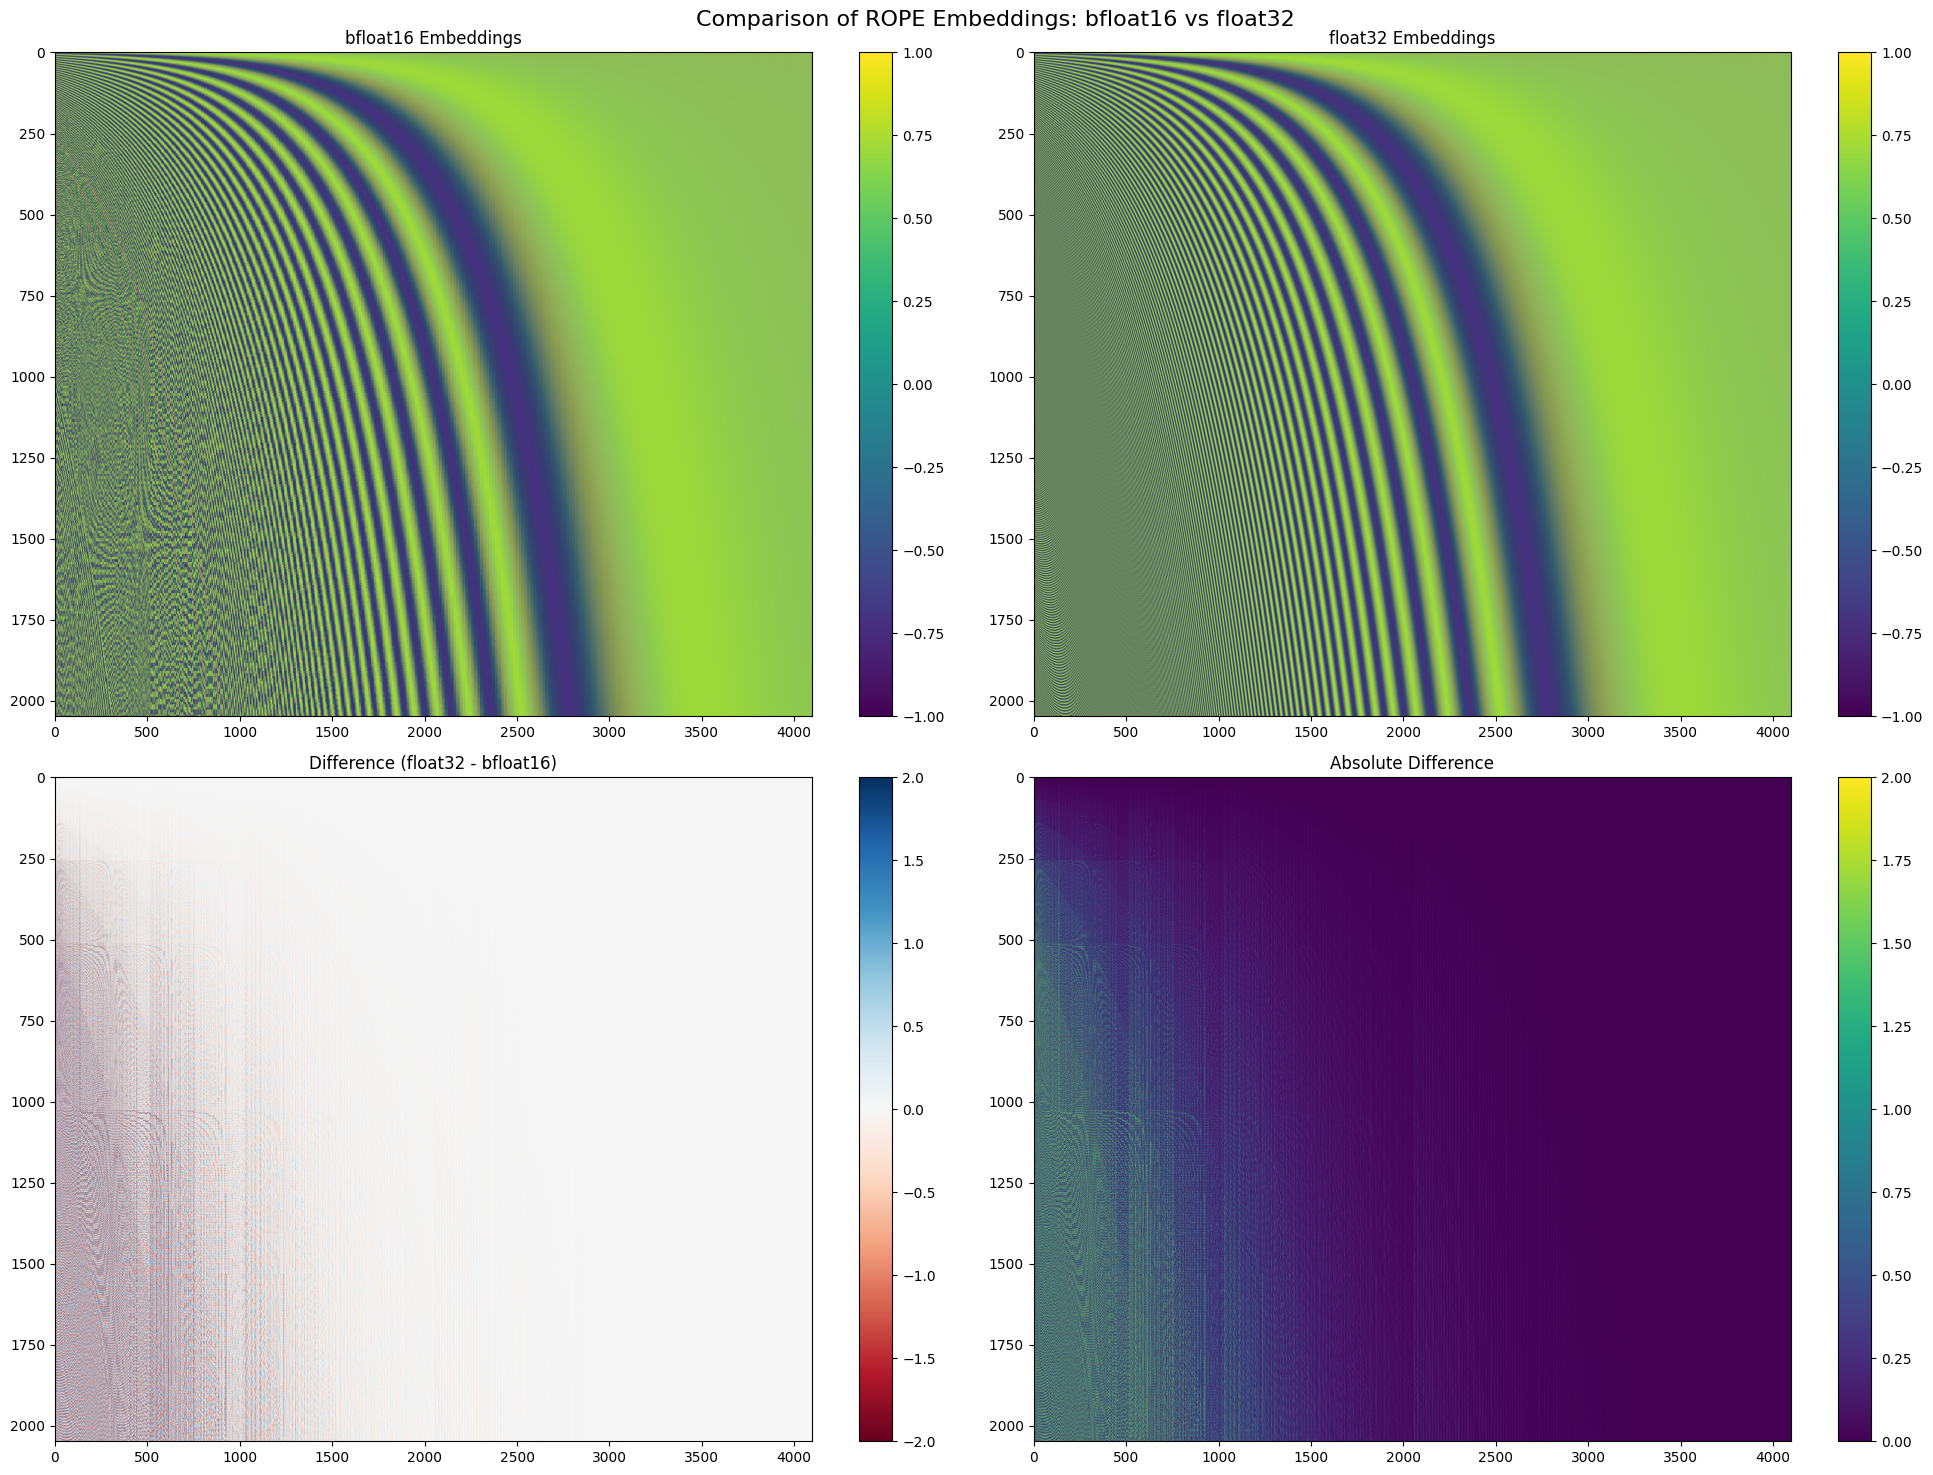

Maximum absolute difference: 2.00000000
Mean absolute difference: 0.16306223
Standard deviation of difference: 0.37444925


In [3]:
# Compare bfloat16 and float32 implementations
def compare_precision_outputs(dim=4096, end=2048, theta=10000.0):
    # Generate embeddings in both precisions
    cos_bf16, sin_bf16 = precompute_freqs_cis(dim, end, dtype_r=torch.bfloat16)
    cos_f32, sin_f32 = precompute_freqs_cis(dim, end, dtype_r=torch.float32)

    # Create positional embeddings
    pos_emb_bf16 = torch.zeros(end, dim)
    pos_emb_bf16[:, 0::2] = cos_bf16
    pos_emb_bf16[:, 1::2] = sin_bf16

    pos_emb_f32 = torch.zeros(end, dim)
    pos_emb_f32[:, 0::2] = cos_f32
    pos_emb_f32[:, 1::2] = sin_f32

    # Compute difference
    diff = (pos_emb_f32 - pos_emb_bf16.to(torch.float32))

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # bfloat16 plot
    im1 = axes[0,0].imshow(pos_emb_bf16.cpu(), aspect='auto', cmap='viridis')
    axes[0,0].set_title('bfloat16 Embeddings')
    plt.colorbar(im1, ax=axes[0,0])

    # float32 plot
    im2 = axes[0,1].imshow(pos_emb_f32.cpu(), aspect='auto', cmap='viridis')
    axes[0,1].set_title('float32 Embeddings')
    plt.colorbar(im2, ax=axes[0,1])

    # Difference plot
    im3 = axes[1,0].imshow(diff.cpu(), aspect='auto', cmap='RdBu')
    axes[1,0].set_title('Difference (float32 - bfloat16)')
    plt.colorbar(im3, ax=axes[1,0])

    # Absolute difference plot
    im4 = axes[1,1].imshow(torch.abs(diff).cpu(), aspect='auto', cmap='viridis')
    axes[1,1].set_title('Absolute Difference')
    plt.colorbar(im4, ax=axes[1,1])

    plt.suptitle('Comparison of ROPE Embeddings: bfloat16 vs float32', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Maximum absolute difference: {torch.abs(diff).max().item():.8f}")
    print(f"Mean absolute difference: {torch.abs(diff).mean().item():.8f}")
    print(f"Standard deviation of difference: {diff.std().item():.8f}")

# Run the comparison
compare_precision_outputs()

## Analyze FF^T matrix

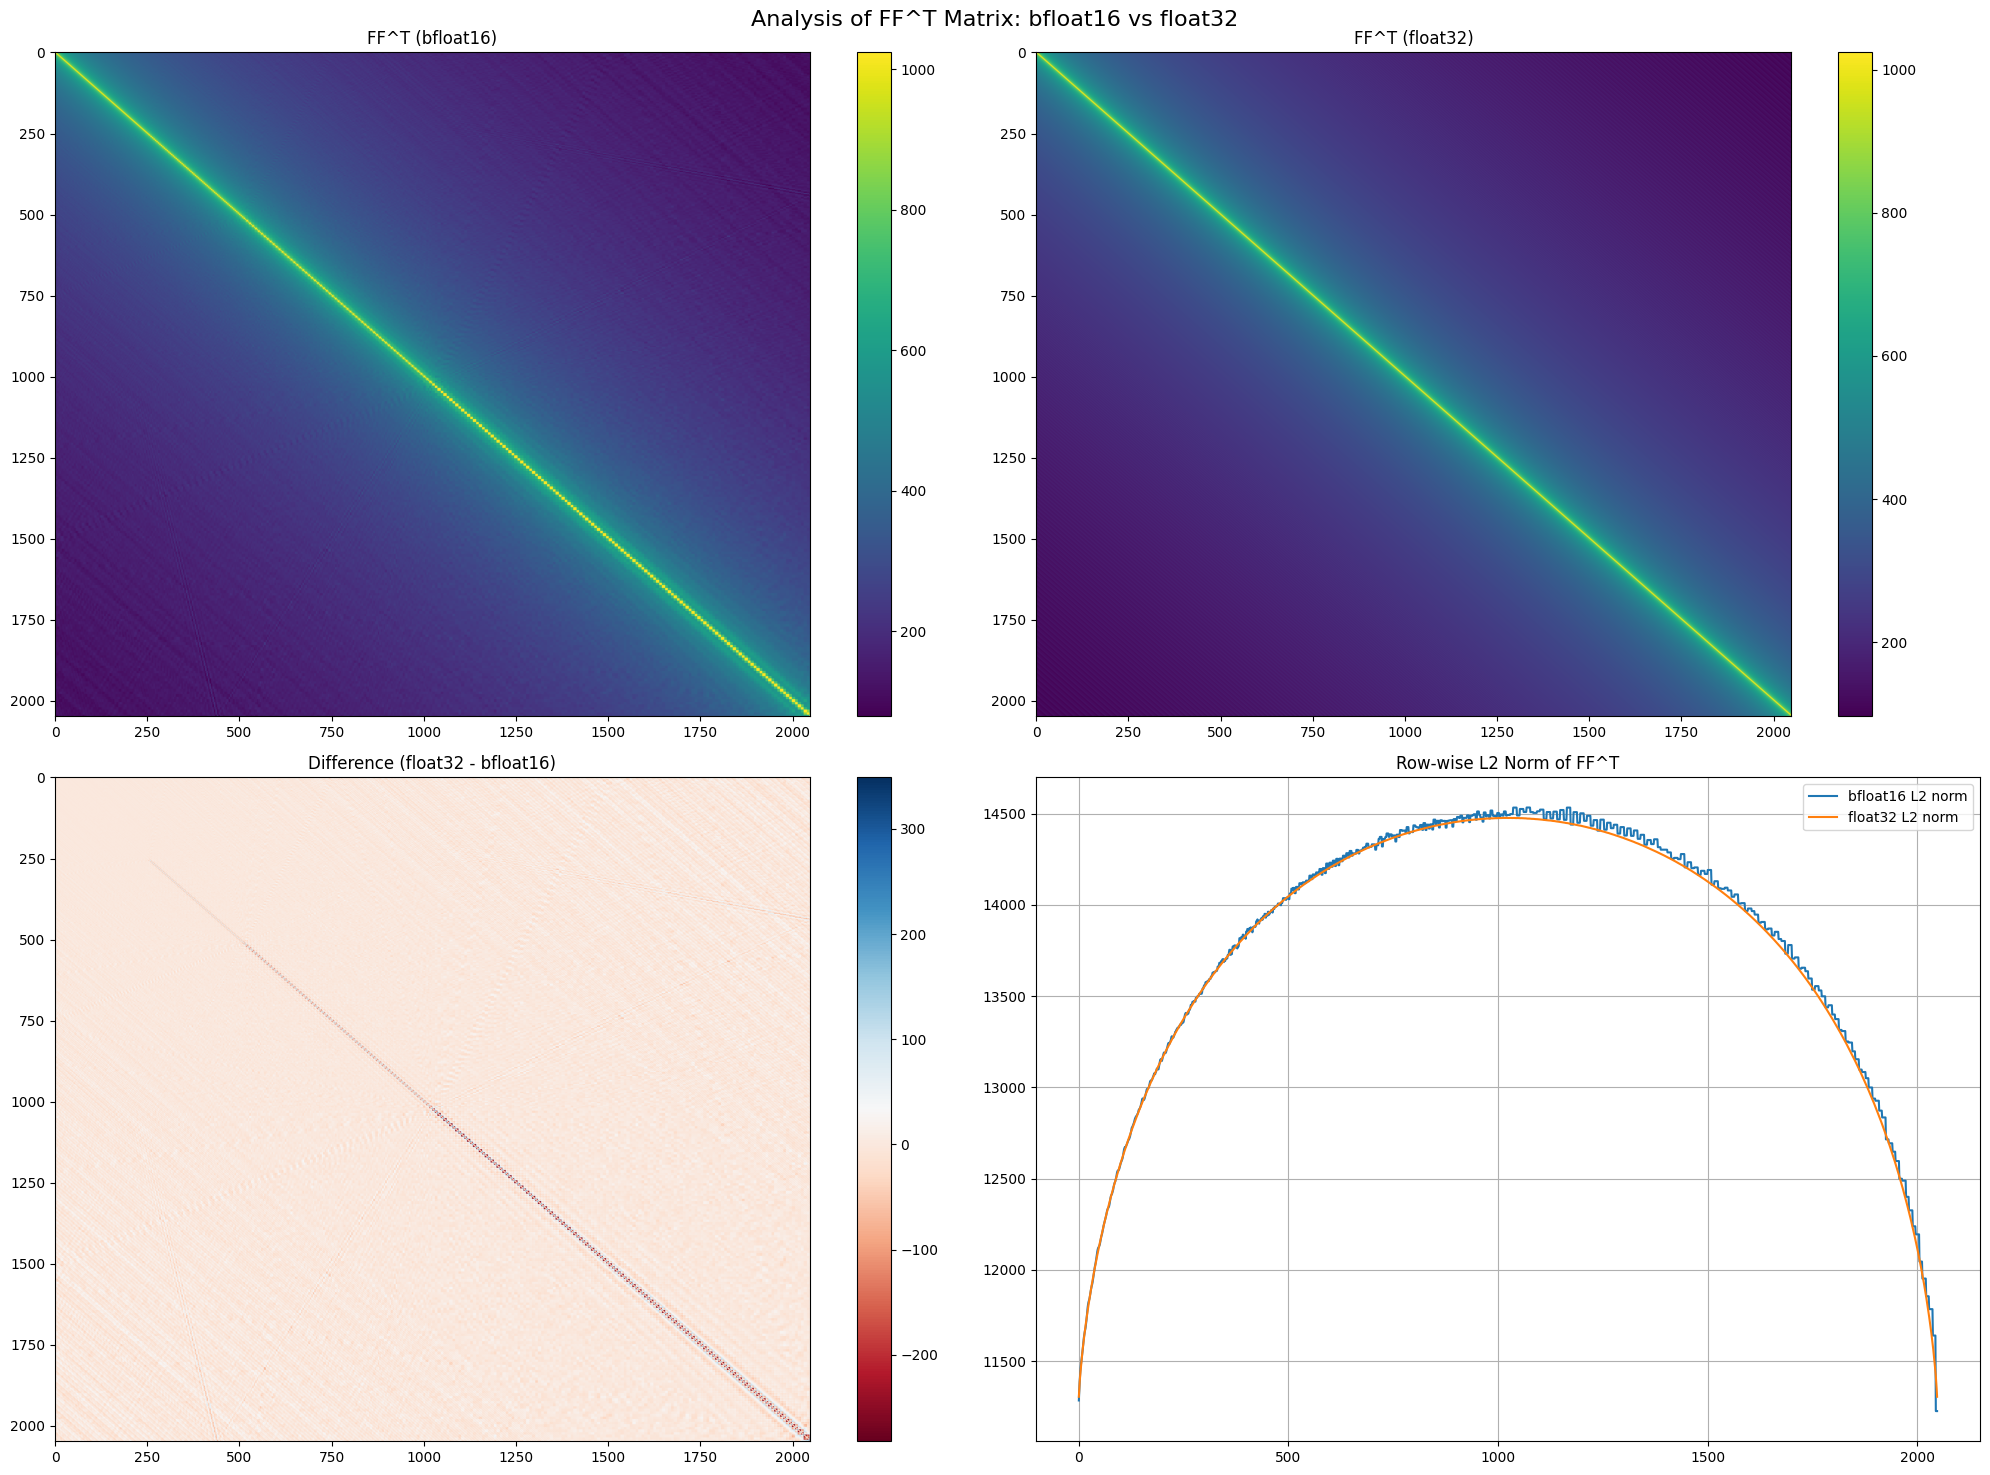

Maximum L2 norm (bfloat16): 14533.4326
Maximum L2 norm (float32): 14476.5771
Maximum absolute difference in matrices: 349.1072
Mean absolute difference in matrices: 8.6283

Theoretical max(FF^T) = dim/2: 1024.0


In [4]:
def analyze_fft_matrix(dim=2048, end=2048, theta=10000.0):
    # Generate embeddings in both precisions
    cos_bf16, sin_bf16 = precompute_freqs_cis(dim, end, dtype_r=torch.bfloat16)
    cos_f32, sin_f32 = precompute_freqs_cis(dim, end, dtype_r=torch.float32)

    # Create F matrices (combining cos and sin)
    F_bf16 = torch.zeros(end, dim, dtype=torch.bfloat16)
    F_bf16[:, 0::2] = cos_bf16
    F_bf16[:, 1::2] = sin_bf16

    F_f32 = torch.zeros(end, dim, dtype=torch.float32)
    F_f32[:, 0::2] = cos_f32
    F_f32[:, 1::2] = sin_f32

    # Compute FF^T for both precisions
    FFT_bf16 = torch.matmul(F_bf16, F_bf16.transpose(-2, -1))
    FFT_f32 = torch.matmul(F_f32, F_f32.transpose(-2, -1))

    # Convert to float32 for comparison
    FFT_bf16 = FFT_bf16.to(torch.float32)

    # Compute difference
    diff = FFT_f32 - FFT_bf16

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # FF^T bfloat16 plot
    im1 = axes[0,0].imshow(FFT_bf16.cpu(), aspect='auto', cmap='viridis')
    axes[0,0].set_title('FF^T (bfloat16)')
    plt.colorbar(im1, ax=axes[0,0])

    # FF^T float32 plot
    im2 = axes[0,1].imshow(FFT_f32.cpu(), aspect='auto', cmap='viridis')
    axes[0,1].set_title('FF^T (float32)')
    plt.colorbar(im2, ax=axes[0,1])

    # Difference plot
    im3 = axes[1,0].imshow(diff.cpu(), aspect='auto', cmap='RdBu')
    axes[1,0].set_title('Difference (float32 - bfloat16)')
    plt.colorbar(im3, ax=axes[1,0])

    # Plot row-wise L2 norms
    l2_norm_bf16 = torch.norm(FFT_bf16, dim=1)
    l2_norm_f32 = torch.norm(FFT_f32, dim=1)

    axes[1,1].plot(l2_norm_bf16.cpu(), label='bfloat16 L2 norm')
    axes[1,1].plot(l2_norm_f32.cpu(), label='float32 L2 norm')
    axes[1,1].set_title('Row-wise L2 Norm of FF^T')
    axes[1,1].legend()
    axes[1,1].grid(True)

    plt.suptitle('Analysis of FF^T Matrix: bfloat16 vs float32', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Maximum L2 norm (bfloat16): {torch.max(l2_norm_bf16).item():.4f}")
    print(f"Maximum L2 norm (float32): {torch.max(l2_norm_f32).item():.4f}")
    print(f"Maximum absolute difference in matrices: {torch.max(torch.abs(diff)).item():.4f}")
    print(f"Mean absolute difference in matrices: {torch.mean(torch.abs(diff)).item():.4f}")
    print(f"\nTheoretical max(FF^T) = dim/2: {dim/2}")

# Run the extended analysis
analyze_fft_matrix()

## Approximate benchmark


Detailed Results:

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 1.0
Times:
  Float32 RoPE: 9.638 ms
  BFloat16 RoPE: 1.447 ms
Difference:
  Absolute: 8.191 ms slower with float32
  Relative: 566.2% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 2.0
Times:
  Float32 RoPE: 1.839 ms
  BFloat16 RoPE: 1.507 ms
Difference:
  Absolute: 0.332 ms slower with float32
  Relative: 22.0% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 4.0
Times:
  Float32 RoPE: 1.639 ms
  BFloat16 RoPE: 1.525 ms
Difference:
  Absolute: 0.114 ms slower with float32
  Relative: 7.5% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 16.0
Times:
  Float32 RoPE: 1.811 ms
  BFloat16 RoPE: 1.677 ms
Difference:
  Absolute: 0.135 ms slower with float32
  Relative: 8.0% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size:

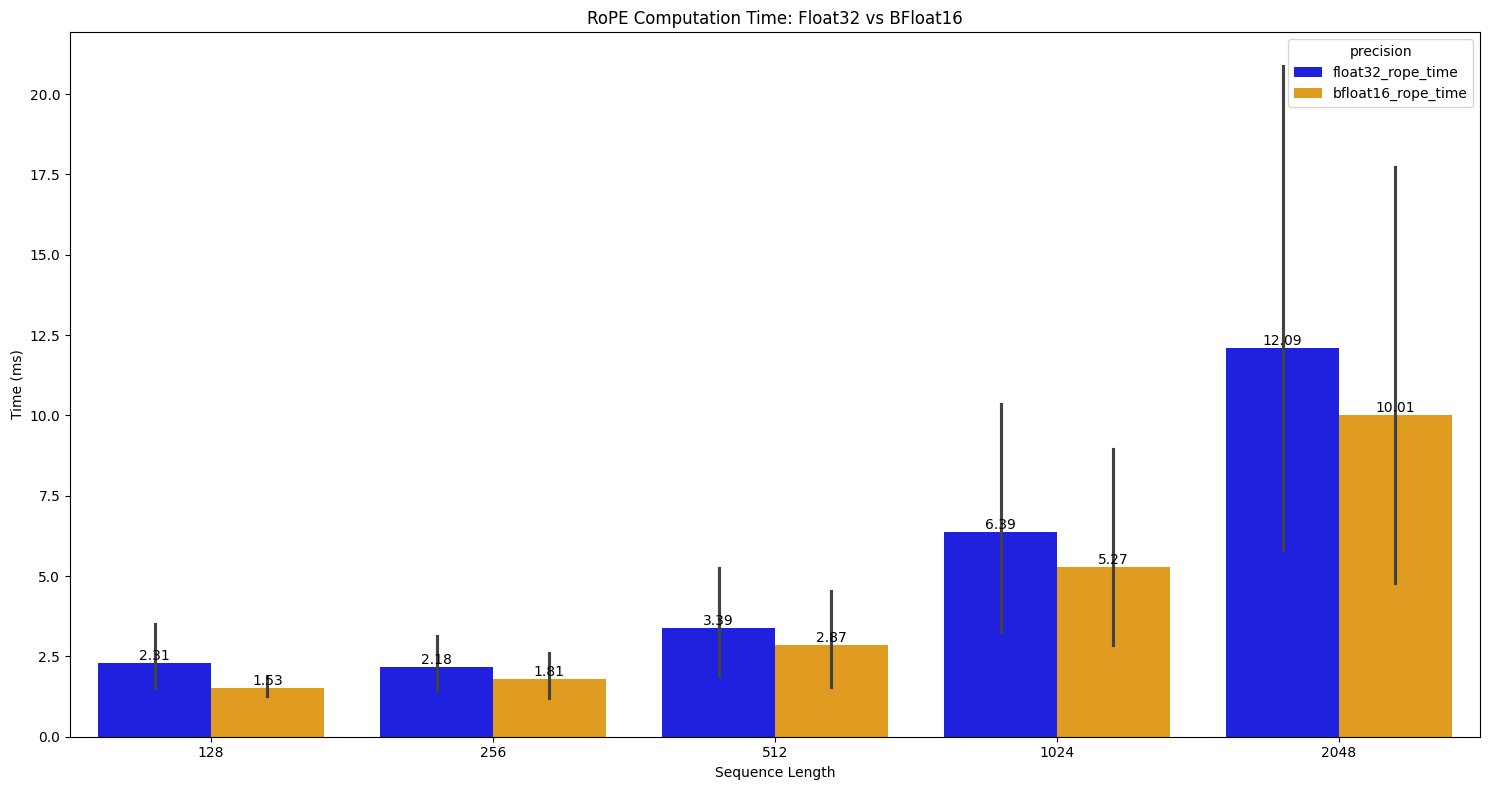


Summary Statistics:
Average slowdown: 23.9%
Max slowdown: 566.2%
Min slowdown: -31.3%

Average time difference: 0.973 ms
Max time difference: 10.032 ms
Min time difference: -0.557 ms


In [5]:
def benchmark_rope_precision(
    dims=[2048],
    seq_lengths=[2048],
    batch_sizes=[24],
    num_heads=16,
    n_runs=100
):
    import time
    import pandas as pd
    import seaborn as sns

    results = []

    for dim in dims:
        for seq_len in seq_lengths:
            for batch_size in batch_sizes:

                f_32_attn = Attention(
                    GPT2Configuration(
                        d_model=dim,
                        block_size=seq_len,
                        use_liger=False,
                        num_heads=num_heads,
                        rope_dtype=torch.float32)
                    ).cuda()
                f_16_attn = Attention(
                    GPT2Configuration(
                        d_model=dim,
                        block_size=seq_len,
                        use_liger=False,
                        num_heads=num_heads,
                        rope_dtype=torch.bfloat16)
                    ).cuda()
                x = torch.randn(batch_size, seq_len, dim, device='cuda')

                try:
                    # Test with RoPE in float32
                    torch.cuda.synchronize()
                    start = time.perf_counter()
                    for _ in range(n_runs):
                        with torch.no_grad():
                            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                                _ = f_32_attn(x)
                        torch.cuda.synchronize()
                    f32_rope_time = (time.perf_counter() - start) / n_runs

                    # Test with RoPE in bfloat16
                    torch.cuda.synchronize()
                    start = time.perf_counter()
                    for _ in range(n_runs):
                        with torch.no_grad():
                            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                                 _ = f_16_attn(x)
                        torch.cuda.synchronize()
                    bf16_rope_time = (time.perf_counter() - start) / n_runs

                    results.append({
                        'dim': dim,
                        'seq_len': seq_len,
                        'batch_size': batch_size,
                        'float32_rope_time': f32_rope_time * 1000,  # ms
                        'bfloat16_rope_time': bf16_rope_time * 1000,  # ms
                    })

                except Exception as e:
                    print(f"Error: {str(e)}")
                    continue

                torch.cuda.empty_cache()

    if not results:
        print("No successful benchmarks were completed!")
        return None

    df = pd.DataFrame(results)

    # Calculate statistics
    df['time_diff_ms'] = df['float32_rope_time'] - df['bfloat16_rope_time']
    df['slowdown_percent'] = (df['float32_rope_time'] / df['bfloat16_rope_time'] - 1) * 100

    # Print detailed results
    print("\nDetailed Results:")
    print("=" * 80)
    for _, row in df.iterrows():
        print(f"\nConfiguration:")
        print(f"  Dimension: {row['dim']}")
        print(f"  Sequence Length: {row['seq_len']}")
        print(f"  Batch Size: {row['batch_size']}")
        print(f"Times:")
        print(f"  Float32 RoPE: {row['float32_rope_time']:.3f} ms")
        print(f"  BFloat16 RoPE: {row['bfloat16_rope_time']:.3f} ms")
        print(f"Difference:")
        print(f"  Absolute: {row['time_diff_ms']:.3f} ms slower with float32")
        print(f"  Relative: {row['slowdown_percent']:.1f}% slower with float32")

    # Create bar plot
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    plot_data = pd.melt(df,
                        id_vars=['dim', 'seq_len', 'batch_size'],
                        value_vars=['float32_rope_time', 'bfloat16_rope_time'],
                        var_name='precision',
                        value_name='time_ms')

    # Create grouped bar plot
    sns.barplot(data=plot_data,
                x='seq_len',
                y='time_ms',
                hue='precision',
                palette=['blue', 'orange'])

    plt.title('RoPE Computation Time: Float32 vs BFloat16')
    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')

    # Add value labels on bars
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.2f')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("=" * 80)
    print(f"Average slowdown: {df['slowdown_percent'].mean():.1f}%")
    print(f"Max slowdown: {df['slowdown_percent'].max():.1f}%")
    print(f"Min slowdown: {df['slowdown_percent'].min():.1f}%")
    print(f"\nAverage time difference: {df['time_diff_ms'].mean():.3f} ms")
    print(f"Max time difference: {df['time_diff_ms'].max():.3f} ms")
    print(f"Min time difference: {df['time_diff_ms'].min():.3f} ms")

    return df

# Run benchmark
results_df = benchmark_rope_precision(
    dims=[768, 1024, 2048],
    seq_lengths=[128, 256, 512, 1024, 2048],
    batch_sizes=[1, 2, 4, 16, 32],
    n_runs=100
)

Running compiled attention benchmark...

Detailed Results (with torch.compile):

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 1.0
Times (Compiled):
  Float32 RoPE: 2.406 ms
  BFloat16 RoPE: 1.626 ms
Difference:
  Absolute: 0.780 ms slower with float32
  Relative: 48.0% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 2.0
Times (Compiled):
  Float32 RoPE: 1.315 ms
  BFloat16 RoPE: 1.412 ms
Difference:
  Absolute: -0.097 ms slower with float32
  Relative: -6.9% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 4.0
Times (Compiled):
  Float32 RoPE: 1.856 ms
  BFloat16 RoPE: 1.651 ms
Difference:
  Absolute: 0.205 ms slower with float32
  Relative: 12.4% slower with float32

Configuration:
  Dimension: 768.0
  Sequence Length: 128.0
  Batch Size: 16.0
Times (Compiled):
  Float32 RoPE: 2.754 ms
  BFloat16 RoPE: 1.682 ms
Difference:
  Absolute: 1.073 ms slower with float32
  Re

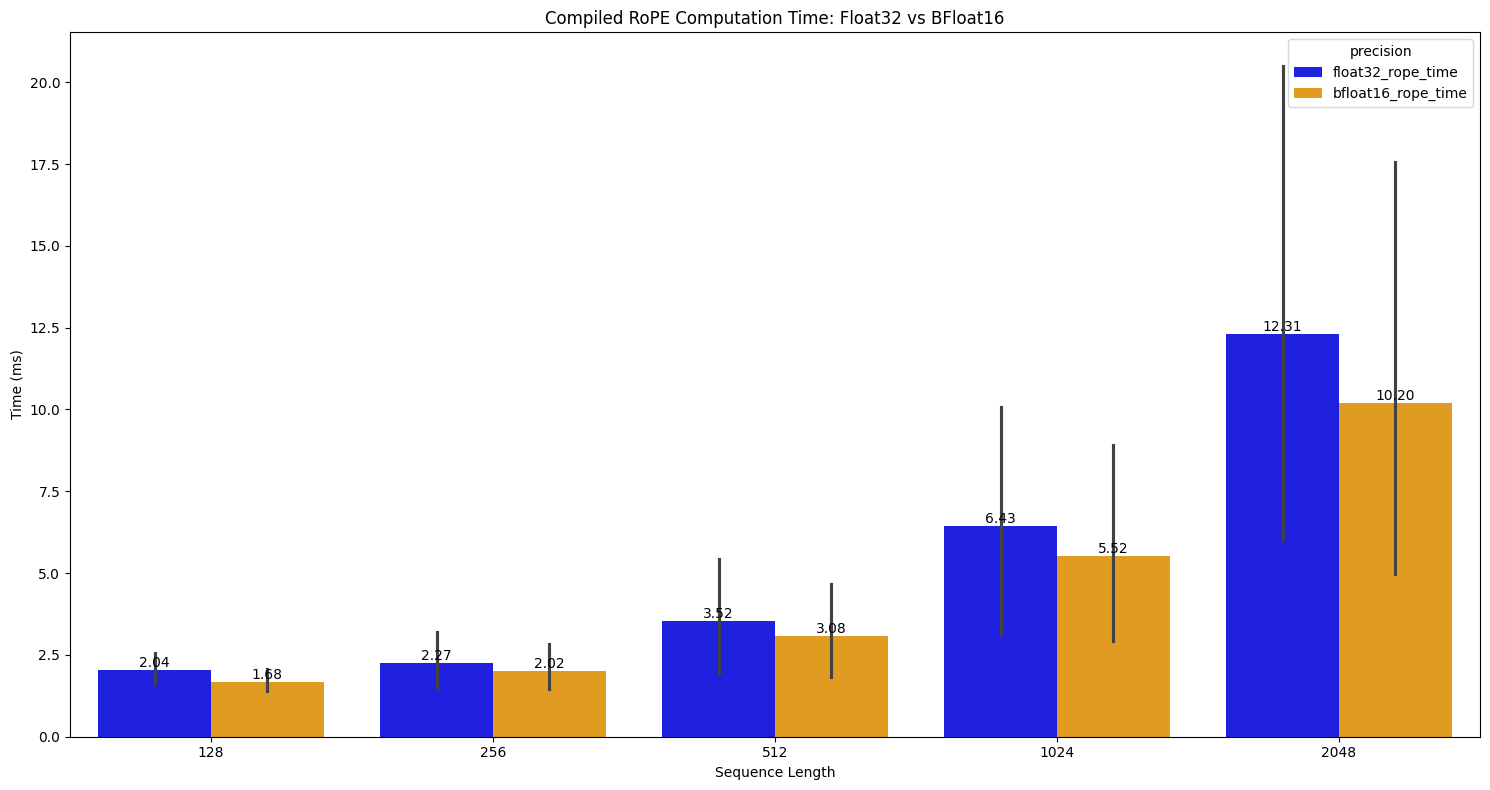


Summary Statistics (Compiled):
Average slowdown: 13.8%
Max slowdown: 126.2%
Min slowdown: -45.0%

Average time difference: 0.817 ms
Max time difference: 9.660 ms
Min time difference: -1.047 ms


In [7]:
def benchmark_rope_precision(
    dims=[2048],
    seq_lengths=[2048],
    batch_sizes=[24],
    num_heads=16,
    n_runs=100
):
    import time
    import pandas as pd
    import seaborn as sns

    results = []

    for dim in dims:
        for seq_len in seq_lengths:
            for batch_size in batch_sizes:

                f_32_attn = Attention(
                    GPT2Configuration(
                        d_model=dim,
                        block_size=seq_len,
                        use_liger=False,
                        num_heads=num_heads,
                        rope_dtype=torch.float32)
                    ).cuda()
                f_16_attn = Attention(
                    GPT2Configuration(
                        d_model=dim,
                        block_size=seq_len,
                        use_liger=False,
                        num_heads=num_heads,
                        rope_dtype=torch.bfloat16)
                    ).cuda()

                # Compile both attention modules
                f_32_attn = torch.compile(f_32_attn)
                f_16_attn = torch.compile(f_16_attn)

                x = torch.randn(batch_size, seq_len, dim, device='cuda')

                try:
                    # Warmup runs
                    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                        _ = f_32_attn(x)
                        _ = f_16_attn(x)

                    # Test with RoPE in float32
                    torch.cuda.synchronize()
                    start = time.perf_counter()
                    for _ in range(n_runs):
                        with torch.no_grad():
                            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                                _ = f_32_attn(x)
                        torch.cuda.synchronize()
                    f32_rope_time = (time.perf_counter() - start) / n_runs

                    # Test with RoPE in bfloat16
                    torch.cuda.synchronize()
                    start = time.perf_counter()
                    for _ in range(n_runs):
                        with torch.no_grad():
                            with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                                _ = f_16_attn(x)
                        torch.cuda.synchronize()
                    bf16_rope_time = (time.perf_counter() - start) / n_runs

                    results.append({
                        'dim': dim,
                        'seq_len': seq_len,
                        'batch_size': batch_size,
                        'float32_rope_time': f32_rope_time * 1000,  # ms
                        'bfloat16_rope_time': bf16_rope_time * 1000,  # ms
                    })

                except Exception as e:
                    print(f"Error: {str(e)}")
                    continue

                torch.cuda.empty_cache()

    if not results:
        print("No successful benchmarks were completed!")
        return None

    df = pd.DataFrame(results)

    # Calculate statistics
    df['time_diff_ms'] = df['float32_rope_time'] - df['bfloat16_rope_time']
    df['slowdown_percent'] = (df['float32_rope_time'] / df['bfloat16_rope_time'] - 1) * 100

    # Print detailed results
    print("\nDetailed Results (with torch.compile):")
    print("=" * 80)
    for _, row in df.iterrows():
        print(f"\nConfiguration:")
        print(f"  Dimension: {row['dim']}")
        print(f"  Sequence Length: {row['seq_len']}")
        print(f"  Batch Size: {row['batch_size']}")
        print(f"Times (Compiled):")
        print(f"  Float32 RoPE: {row['float32_rope_time']:.3f} ms")
        print(f"  BFloat16 RoPE: {row['bfloat16_rope_time']:.3f} ms")
        print(f"Difference:")
        print(f"  Absolute: {row['time_diff_ms']:.3f} ms slower with float32")
        print(f"  Relative: {row['slowdown_percent']:.1f}% slower with float32")

    # Create bar plot
    plt.figure(figsize=(15, 8))
    plot_data = pd.melt(df,
                        id_vars=['dim', 'seq_len', 'batch_size'],
                        value_vars=['float32_rope_time', 'bfloat16_rope_time'],
                        var_name='precision',
                        value_name='time_ms')

    sns.barplot(data=plot_data,
                x='seq_len',
                y='time_ms',
                hue='precision',
                palette=['blue', 'orange'])

    plt.title('Compiled RoPE Computation Time: Float32 vs BFloat16')
    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')

    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.2f')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics (Compiled):")
    print("=" * 80)
    print(f"Average slowdown: {df['slowdown_percent'].mean():.1f}%")
    print(f"Max slowdown: {df['slowdown_percent'].max():.1f}%")
    print(f"Min slowdown: {df['slowdown_percent'].min():.1f}%")
    print(f"\nAverage time difference: {df['time_diff_ms'].mean():.3f} ms")
    print(f"Max time difference: {df['time_diff_ms'].max():.3f} ms")
    print(f"Min time difference: {df['time_diff_ms'].min():.3f} ms")

    return df

# Run benchmark
print("Running compiled attention benchmark...")
results_df = benchmark_rope_precision(
    dims=[768, 1024, 2048],
    seq_lengths=[128, 256, 512, 1024, 2048],
    batch_sizes=[1, 2, 4, 16, 32],
    n_runs=100
)